# Figure S18. Supplementary results of random-effects meta-analysis on the findings across alternative modeling configurations

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [15]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.stats.multitest
import pymare

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
    "micamics": os.path.join(os.environ["PROJECT_DIR"], "output", "micamics")
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)
from utils import transform, plot

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = '#44546A'
add_text = True # add statistics as text to some figures

In [4]:
meta_results = pd.read_csv('p_pnc200_IE_age_meta.csv', index_col=0)

## A. $I^2$ heterogeneity index across alternative models

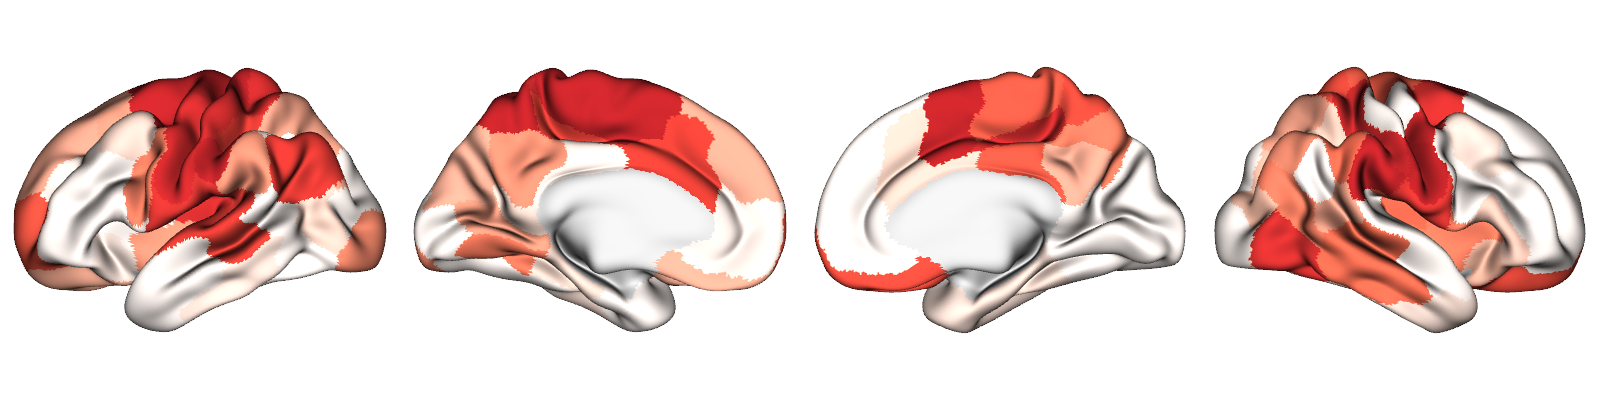

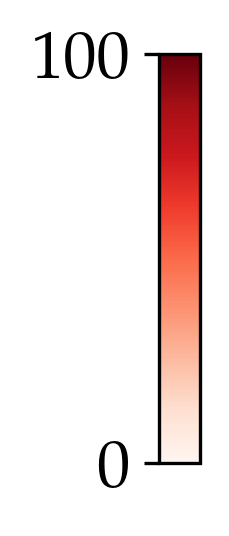

In [5]:
plot.plot_surface(
    transform.deparcellate_surf(meta_results['I^2'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    cmap='Reds', cbar=True, vrange=(0, 100),
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='row',
)

## B. Significant pooled age effects excluding parcels with significant heterogeneity across alternative models

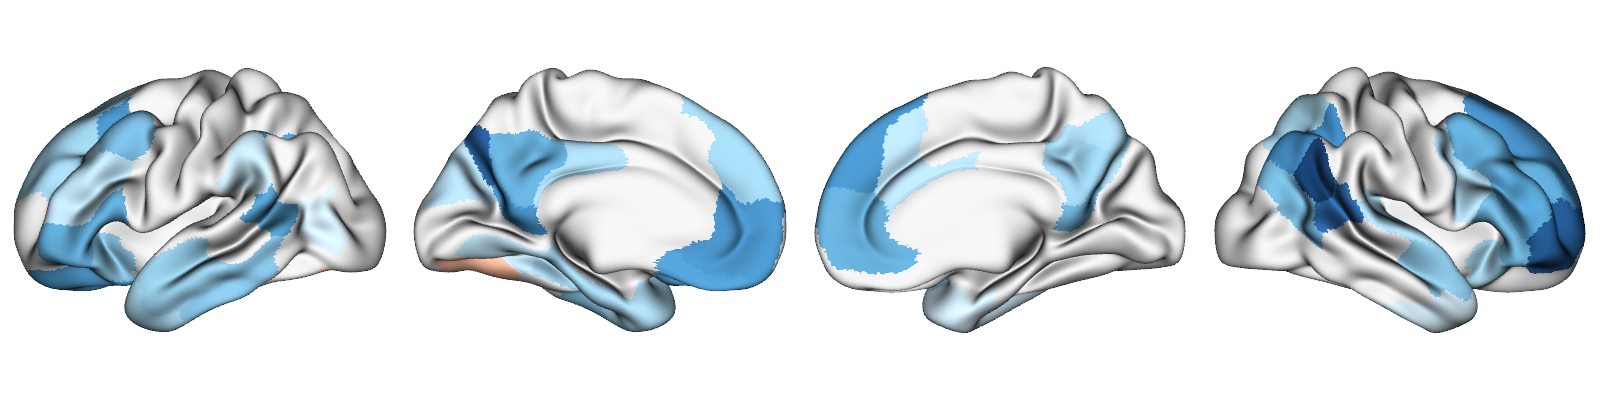

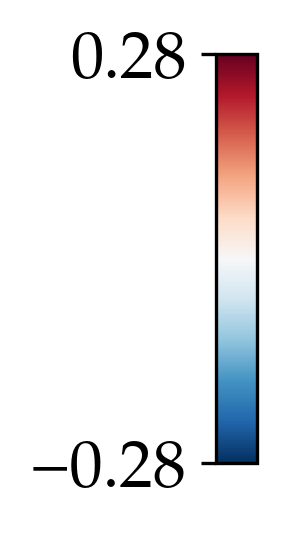

In [6]:
sig_nonhet_estimates = meta_results['estimate'][(meta_results['p_fdr']<0.05) & (meta_results['p(Q)']>=0.05)]
vmin = min(sig_nonhet_estimates.values.min(), -sig_nonhet_estimates.values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(
        sig_nonhet_estimates, 'schaefer-100', concat=True, space='fsaverage'
    ), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='row',
)

## S13C. Pooled effects additionally including map-free models

In [16]:
all_stats = {}
for alt in ['main', 'sc_temp', 'sch200', '2maps', 'nmda_gabaa', '4maps', 'inter', 'altseed', 'homo', 'node']:
    all_stats[alt] = pd.read_csv(f"p_pnc200_{alt}_IE_age_stats.csv", index_col=0)
parcels = transform.load_ordered_parcel_labels('schaefer-100')

# for schaefer-200 reparcellate it into schaefer-100 so the maps can be combined
all_stats['sch200reparc'] = transform.parcellate_surf(transform.deparcellate_surf(all_stats['sch200'], 'schaefer-200'), 'schaefer-100', concat=True)
all_stats['sch200reparc'].columns = all_stats['main'].columns
all_stats['sch200reparc']['N'] = all_stats['sch200reparc']['N'].round().astype('int')

# convert Rs and Ns of analyses reported in Fig 5 to dataframes
# which will be used in the meta-analyses
meta_alts_all = ['main', 'sc_temp', 'sch200reparc', '2maps', 'nmda_gabaa', '4maps', 'inter', 'altseed', 'homo', 'node']
all_Rs = pd.DataFrame({k: all_stats[k]['r'] for k in meta_alts_all})
all_Ns = pd.DataFrame({k: all_stats[k]['N'].astype('int') for k in meta_alts_all})

# in each node run a REML meta-aanlysis using PyMARE
# with the partial correlation of age with <I_Ei> as the effect size
meta_results_all = {}
for parc in parcels:
    dset = pymare.effectsize.OneSampleEffectSizeConverter(
        r = all_Rs.loc[parc, :], 
        n = all_Ns.loc[parc, :]
    ).to_dataset(measure='R')
    est = pymare.estimators.VarianceBasedLikelihoodEstimator(method="REML").fit_dataset(dset)
    results = est.summary()
    meta_results_all[parc] = results.to_df().iloc[0, 1:]
    meta_het_stats = results.get_heterogeneity_stats()
    meta_results_all[parc]['I^2'] = meta_het_stats['I^2'][0]
    meta_results_all[parc]['p(Q)'] = meta_het_stats['p(Q)'][0]
meta_results_all = pd.DataFrame(meta_results_all).T.astype(float)
# FDR correction
_, meta_results_all['p_fdr'] = statsmodels.stats.multitest.fdrcorrection(meta_results_all['p-value'])

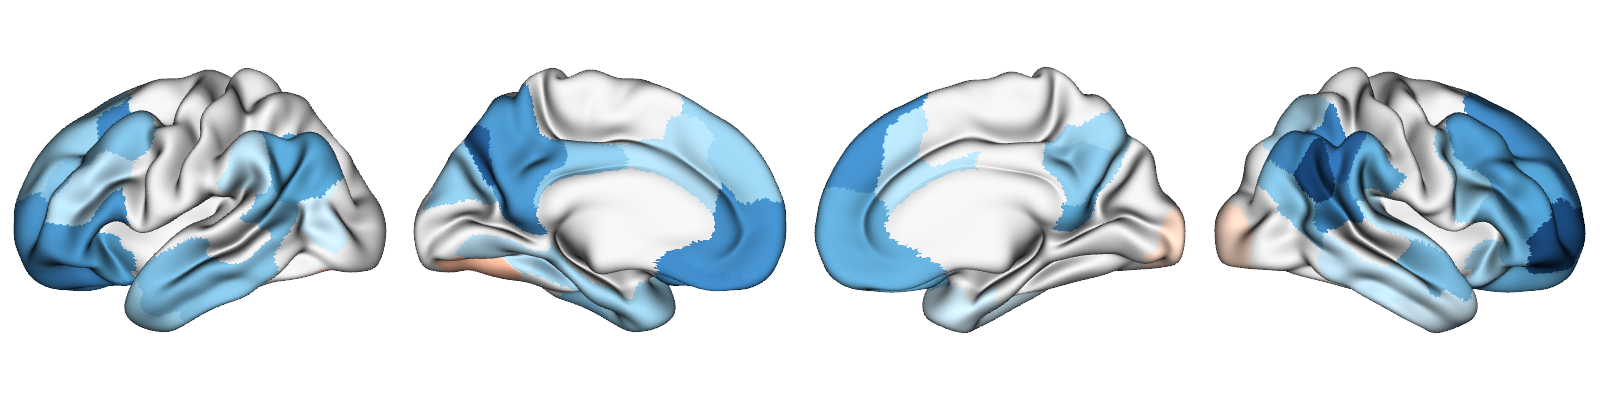

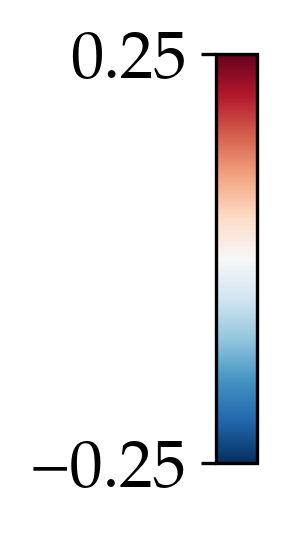

In [17]:
vmin = min(meta_results_all['estimate'].values.min(), -meta_results_all['estimate'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(
        meta_results_all['estimate'][meta_results_all['p_fdr']<0.05], 
        'schaefer-100', concat=True, space='fsaverage'
    ), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='row',
)